<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/Lecture2_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![대체 텍스트](https://raw.githubusercontent.com/deepnoid/education/master/7.%20Deep%20Learning%20Keras/dataset/deepnoid_logo.jpg)

In [1]:
!git clone https://github.com/Pulsar-kkaturi/Deepnoid-Education.git

Cloning into 'Deepnoid-Education'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 258 (delta 81), reused 200 (delta 47), pack-reused 0
Receiving objects: 100% (258/258), 32.92 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (81/81), done.


# 모듈 불러오기

In [2]:
from keras import applications, optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import *
from skimage.transform import rotate
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import os

# 경로 설정하기

In [3]:
BASE_PATH = './Deepnoid-Education/dataset/xray_abd_chest'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'TRAIN')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'VAL')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'TEST', 'abd2.png')

# 하이퍼 파라미터

하이퍼 파라미터를 이용해 인공지능 모델을 조정합니다.  
주로 사용하는 하이퍼 파라미터는 다음과 같습니다.

In [4]:
IMG_HEIGHT, IMG_WIDTH = (256, 256)
EPOCHS = 10
BATCH_SIZE = 5
LEARNING_RATE = 1e-4 
DECAY_RATE = 0
INIT_FILTERS = 32
ACTIVATION_FN = 'elu' # relu, elu, sigmoid
DROP_RATE = 0.25

# 데이터 불러오기
AI 모델 학습에 사용할 데이터를 불러오겠습니다.  

In [5]:
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_PATH,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    seed=42)
val_generator = val_datagen.flow_from_directory(directory=VAL_DATA_PATH,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary',
                                                shuffle=False,
                                                seed=42)

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


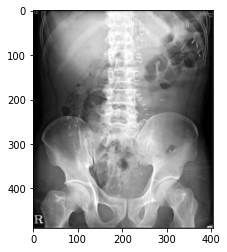

(489, 404, 3)


In [6]:
img = plt.imread(TEST_DATA_PATH)
plt.imshow(img, cmap='Greys')
plt.show()
print(img.shape)

# **AI 모델을 구성하는 레이어 만들기**

AI 모델은 여러 개의 레이어를 쌓아 올려 만듭니다.  
가장 대표적인 레이어 구조인 **CONV-BN-ACT-POOL** 구조를 만들어 보겠습니다.

먼저 데이터가 들어가는 첫 번째 레이어를 만들어 봅시다.

In [7]:
first_layer = Input(shape=(32, 32, 3))

그 다음으로 데이터의 특징을 추출할 Convolution 레이어를 연결하겠습니다.

In [8]:
second_layer = Conv2D(filters=8, kernel_size=(3, 3), activation=None, padding='same')(first_layer)

다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.

In [9]:
third_layer = BatchNormalization()(second_layer)

Batch Normalization 이후 신호를 변환하여 다음 뉴런으로 전달하는 Activation function 레이어를 추가합니다.

In [10]:
fourth_layer = Activation('relu')(third_layer)

다음으로 이미지 사이즈를 줄여주는 Pooling 레이어를 연결합니다.

In [11]:
fifth_layer = MaxPool2D(strides=(2, 2))(fourth_layer)

그 후 모든 뉴런을 일렬로 늘어세우는 Flatten 레이어를 만듭니다.

In [12]:
sixth_layer = Flatten()(fifth_layer)

일렬로 늘어세운 후 이전 계층의 모든 뉴런을 연결해주는 Fully connected(Dense) 레이어를 연결합니다.

In [13]:
seventh_layer = Dense(12, activation = 'relu')(sixth_layer)

Dropout 레이어를 활용해 일부 뉴런들을 무작위로 학습에서 배제하도록 합시다.

In [14]:
eighth_layer = Dropout(0.25)(seventh_layer)

마지막으로 최종 결과물을 출력해주는 레이어를 만들어 줍니다.

In [15]:
final_layer =  Dense(1, activation='sigmoid')(eighth_layer)

지금까지 만든 레이어를 Model 함수에 넣어 연결하면 모델이 완성됩니다.

In [16]:
sample_model = Model(first_layer, final_layer)
sample_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                24588 

# **X-ray 이미지 구분하는 AI 모델 만들기**

앞에서 배운 지식을 바탕으로  
모델 구조가 간단하고 준수한 성능을 보이는 VGG16 모델을 직접 만들어보겠습니다.

In [17]:
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

filters = INIT_FILTERS
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(input_layer)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

l = Flatten()(l)
l = Dense(1024, activation = ACTIVATION_FN)(l)
l = Dropout(DROP_RATE)(l)
l = Dense(512, activation = ACTIVATION_FN)(l)
l = Dropout(DROP_RATE)(l)
output_layer = Dense(1, activation='sigmoid')(l)

model= Model(input_layer, output_layer)
model.compile(optimizer=Adam(lr=LEARNING_RATE, 
                             epsilon=1e-8,
                             decay=DECAY_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 32)      0   

# AI 모델 훈련하기

이렇게 준비한 AI 모델을 fit_generator 함수를 이용해 훈련시킬 수 있습니다.

In [18]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n // BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=val_generator,
                              validation_steps=val_generator.n // BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
13/13 [==============================] - 10s 148ms/step - loss: 1.0109 - accuracy: 0.7341 - val_loss: 3.8616 - val_accuracy: 0.5000
Epoch 2/10
13/13 [==============================] - 1s 108ms/step - loss: 0.7259 - accuracy: 0.8569 - val_loss: 9.6465 - val_accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - 2s 118ms/step - loss: 0.0795 - accuracy: 0.9785 - val_loss: 9.9789 - val_accuracy: 0.5000
Epoch 4/10
13/13 [==============================] - 1s 110ms/step - loss: 0.5159 - accuracy: 0.9142 - val_loss: 12.6123 - val_accuracy: 0.5000
Epoch 5/10
13/13 [==============================] - 1s 112ms/step - loss: 0.3463 - accuracy: 0.9415 - val_loss: 5.0310 - val_accuracy: 0.5000
Epoch 6/10
13/13 [==============================] - 1s 112ms/step - loss: 0.5540 - accuracy: 0.8707 - val_loss: 5.7106 - val_accuracy: 0.5000
Epoch 7/10
13/13 [==============================] - 1s 108ms/step - loss: 0.3179 - accuracy: 0.9535 - val_loss: 7.8360 - val_accuracy: 0.5000
Epoc

# 훈련 결과 확인하기

훈련 결과를 한 눈에 확인할 수 있는 그래프를 만들어 보겠습니다.

먼저 그래프의 **y축에 사용할 값**들을 **history 항목**에서 추출해 봅시다.

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

다음으로 그래프의 **x축** 값으로 사용할 **epoch** 을 뽑아 보겠습니다.

In [20]:
epochs = range(1,len(acc)+1)

값들을 확인해볼까요?

In [21]:
acc

[0.7846153974533081,
 0.8461538553237915,
 0.9538461565971375,
 0.9230769276618958,
 0.9230769276618958,
 0.9076923131942749,
 0.9846153855323792,
 0.9230769276618958,
 0.9076923131942749,
 0.9538461565971375]

In [22]:
val_acc

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [23]:
loss

[1.0432980060577393,
 0.6810811758041382,
 0.13829486072063446,
 0.48031941056251526,
 0.40483081340789795,
 0.42576709389686584,
 0.11356111615896225,
 0.19687685370445251,
 0.5338226556777954,
 0.20979827642440796]

In [24]:
val_loss

[3.8615670204162598,
 9.646465301513672,
 9.978872299194336,
 12.612260818481445,
 5.030977249145508,
 5.710585594177246,
 7.835955619812012,
 10.239974021911621,
 10.468313217163086,
 7.57915735244751]

In [25]:
list(epochs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

이 값들을 이용해 그래프를 만들어 보겠습니다.

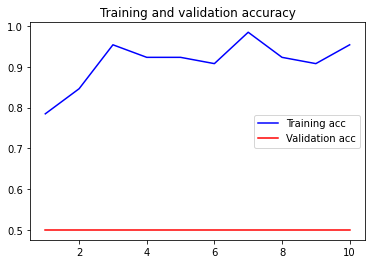

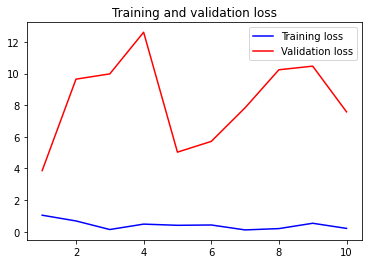

In [26]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 테스트하기

마지막으로 AI 모델이 실제로 X-ray 이미지를 잘 분류하는지 확인해보겠습니다.

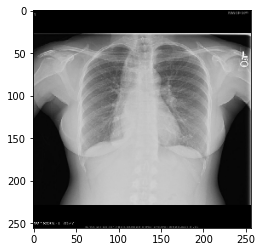

Predicted: Abd X-ray , Score: 1.0


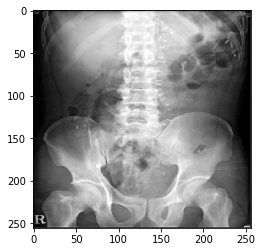

Predicted:  Abd X-ray , Score: 1.0


In [27]:
img1_path = './Deepnoid-Education/dataset/xray_abd_chest/TEST/chest2.png'
img2_path = './Deepnoid-Education/dataset/xray_abd_chest/TEST/abd2.png'

img1 = image.load_img(img1_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img2 = image.load_img(img2_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

plt.imshow(img1)
plt.show()

img1 = image.img_to_array(img1)
img1 /= 255.
img1 = img1[np.newaxis, :, :, :]
score1 = model.predict(img1)
print('Predicted:', 'Chest X-ray' if score1 < 0.5 else 'Abd X-ray', ', Score:', score1[0,0])

plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
img2 /= 255.
img2 = img2[np.newaxis, :, :, :]
score2 = model.predict(img2)
print('Predicted: ', 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray', ', Score:', score2[0,0])